In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm 
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
"""Load the datasets."""
images = loadmat('images.mat') 
classes = loadmat('classes')

images=images['images'].T  
classes=classes['classes'].T

In [3]:
images2d = np.zeros((images.shape[0], 192, 168))
for i in range(images.shape[0]):
    images2d[i] = images[i].reshape(168, 192).T

In [4]:
#replace images and classes with light_images and light_classes for co
X_train, X_test, y_train, y_test = train_test_split(images2d, classes, test_size=0.3, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1689, 192, 168)
(1689, 1)
(725, 192, 168)
(725, 1)


In [5]:
import cv2

def extract_phase_congruency_features(image, kernels, num_orientations=8, num_scales=5, downsample_factor=8, epsilon=1e-6):
    """
    Extract OGPCI features from a grayscale face image using the standard Gabor kernel bank.

    Parameters:
        image (2D np.ndarray): Grayscale image (e.g. 128x128).
        kernels (list): List of Gabor kernels ordered by scale-major then orientation-minor.
        num_orientations (int): Number of orientations (typically 8).
        num_scales (int): Number of scales (typically 5).
        downsample_factor (int): Factor for downsampling.
        epsilon (float): Small constant to avoid division by zero.

    Returns:
        np.ndarray: 1D vector of concatenated downsampled OGPCIs (augmented phase congruency feature vector).
    """
    h, w = image.shape
    image = image.astype(np.float32)
    
    # Group kernels by orientation (reshape into [num_orientations][num_scales])
    kernel_bank = kernels.reshape((num_scales, num_orientations, 31, 31))
    kernel_bank = kernel_bank.transpose((1, 0, 2, 3))

    ogpcis = []
    
    for v, kernel_set in enumerate(kernel_bank):  # loop over orientations
        A_sum = np.zeros((h, w), dtype=np.float32)
        energy_sum = np.zeros_like(A_sum)

        phi_list = []
        A_list = []

        # Step 1: Compute magnitude and phase for each scale at orientation v
        for u in range(num_scales):
            kernel = kernel_set[u]
            response = cv2.filter2D(image, cv2.CV_64F, kernel)
            real = np.real(response)
            imag = np.imag(response)

            A = np.sqrt(real**2 + imag**2)
            phi = np.arctan2(imag, real)

            A_list.append(A)
            phi_list.append(phi)
            A_sum += A

        # Step 2: Compute mean phase at this orientation
        sin_sum = np.sum([A_list[i] * np.sin(phi_list[i]) for i in range(num_scales)], axis=0)
        cos_sum = np.sum([A_list[i] * np.cos(phi_list[i]) for i in range(num_scales)], axis=0)
        phi_mean = np.arctan2(sin_sum + epsilon, cos_sum + epsilon)

        # Step 3: Compute oriented Gabor phase congruency image (OGPCI)
        for u in range(num_scales):
            delta_phi = np.cos(phi_list[u] - phi_mean) - np.abs(np.sin(phi_list[u] - phi_mean))
            energy_sum += A_list[u] * delta_phi

        ogpci = energy_sum / (A_sum + epsilon)

        # Step 4: Downsample OGPCI
        ogpci_down = cv2.resize(ogpci, (w // downsample_factor, h // downsample_factor)).flatten()
        ogpcis.append(ogpci_down)

    # Step 5: Concatenate downsampled OGPCIs
    return np.concatenate(ogpcis)

def build_gabor_kernels(scales=5, orientations=8, ksize=31, fmax=0.25):
    kernels = []
    for u in range(scales):
        for v in range(orientations):
            theta = v * np.pi / orientations
            lambd = 1 / (fmax / (2 ** (u / 2)))
            kernel = cv2.getGaborKernel((ksize, ksize), sigma=4.0, theta=theta,
                                        lambd=lambd, gamma=0.5, psi=0, ktype=cv2.CV_64F)
            kernels.append(kernel)
    return np.array(kernels)

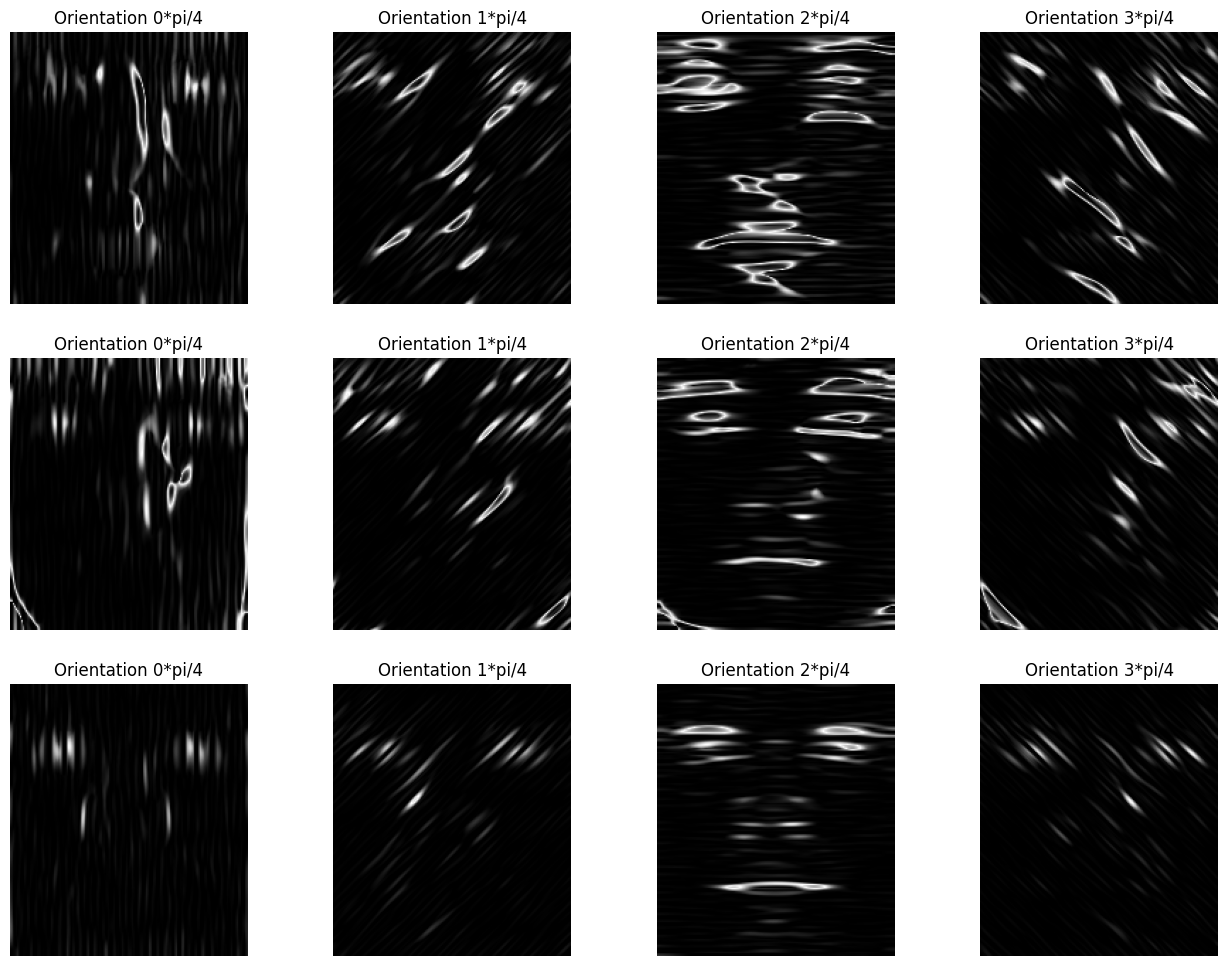

In [58]:
rng = np.random.seed(seed=1)

# Select the first 3 images from your train set
random_indices = np.random.choice(X_train.shape[0], size=3, replace=False)
sample_images = X_train[random_indices]

# Image dimensions
h, w = sample_images[0].shape
num_orientations = 4

kernels = build_gabor_kernels(scales=5, orientations=num_orientations)
plt.figure(figsize=(16, 12))
for idx, img in enumerate(sample_images):
    # Extract features with downsample_factor = 1 (i.e., no downsampling)
    features = extract_phase_congruency_features(
        image=img,
        kernels=kernels,
        num_orientations=num_orientations,
        num_scales=5,
        downsample_factor=1
    )
    
    # Reshape the features into (num_orientations, h, w)
    ogpci_maps = features.reshape((num_orientations, h, w))
    
    for i, v in enumerate(ogpci_maps):
        plt.subplot(3, 4, 4*idx + i + 1)
        plt.imshow(-v, cmap='gray')
        plt.title(f'Orientation {i}*pi/4')
        plt.axis('off')

plt.show()